# Model On Demand Server

## Create Project

In [1]:
import mlrun

In [2]:
# Set the project name:
project_name = "model-on-demand"

# Create the project:
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2022-05-19 14:49:21,534 [info] loaded project model-on-demand from MLRun DB


## Train Multiple Models

In [3]:
# Import the Auto Trainer:
auto_trainer = mlrun.import_function("hub://auto_trainer")

# Display doc stirng:
auto_trainer.doc()

function: auto-trainer
Automatic train, evaluate and predict functions for the ML frameworks - Scikit-Learn, XGBoost and LightGBM.
default handler: train
entry points:
  train: Training the given model on the given dataset.
    context(MLClientCtx)  - MLRun context., default=
    dataset(DataItem)  - The dataset to train the model on. Can be either a URI or a FeatureVector., default=
    drop_columns(List[str])  - str or a list of strings that represent the columns to drop., default=None
    model_class(str)  - The class of the model, e.g. `sklearn.linear_model.LogisticRegression`., default=None
    model_name(str)  - The model's name to use for storing the model artifact, default to 'model'., default=model
    tag(str)  - The model's tag to log with., default=
    label_columns(Optional[Union[str, List[str]]])  - The target label(s) of the column(s) in the dataset. for Regression or Classification tasks., default=None
    sample_set(DataItem)  - A sample set of inputs for the model fo

In [4]:
# Preapare the model dictionary:
models = {
    "RandomForestClassifier": None,
    "GradientBoostingClassifier": None,
    "ExtraTreesClassifier": None
}

# Iterate thourgh models and train them:
for model in models:
    # Run the training:
    auto_trainer_run = auto_trainer.run(
        name=f"{model}-training",
        inputs={"dataset": "https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv"},
        params={
            "model_name": model,
            "model_class": f"sklearn.ensemble.{model}",
            "label_columns": "labels"
        },
        local=True
    )
    # Store the model trained:
    models[model] = auto_trainer_run.outputs["model"]

> 2022-05-19 14:49:21,738 [info] starting run RandomForestClassifier-training uid=8612d3f21ef0447f96f19bdfed1a6d7d DB=http://mlrun-api:8080
> 2022-05-19 14:49:22,088 [info] test_set or train_test_split_size are not provided, setting train_test_split_size to 0.2
> 2022-05-19 14:49:22,412 [info] Sample set not given, using the whole training set as the sample set
> 2022-05-19 14:49:23,514 [info] training 'RandomForestClassifier'


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-on-demand-guyl,...ed1a6d7d,0,May 19 14:49:21,completed,RandomForestClassifier-training,v3io_user=guylkind=owner=guylhost=jupyter-guyl-66857b7999-9pzk7,dataset,model_name=RandomForestClassifiermodel_class=sklearn.ensemble.RandomForestClassifierlabel_columns=labels,accuracy=0.9545f1_score=0.9547038327526132precision_score=0.9706477732793523recall_score=0.9392752203721841,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2022-05-19 14:49:26,505 [info] run executed, status=completed
> 2022-05-19 14:49:26,507 [info] starting run GradientBoostingClassifier-training uid=ade68544cb2d48e68721172f4e4f0444 DB=http://mlrun-api:8080
> 2022-05-19 14:49:26,632 [info] test_set or train_test_split_size are not provided, setting train_test_split_size to 0.2
> 2022-05-19 14:49:26,783 [info] Sample set not given, using the whole training set as the sample set
> 2022-05-19 14:49:26,788 [info] training 'GradientBoostingClassifier'


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-on-demand-guyl,...4e4f0444,0,May 19 14:49:26,completed,GradientBoostingClassifier-training,v3io_user=guylkind=owner=guylhost=jupyter-guyl-66857b7999-9pzk7,dataset,model_name=GradientBoostingClassifiermodel_class=sklearn.ensemble.GradientBoostingClassifierlabel_columns=labels,accuracy=0.9595f1_score=0.9587366276107999precision_score=0.9781704781704782recall_score=0.9400599400599401,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2022-05-19 14:49:29,113 [info] run executed, status=completed
> 2022-05-19 14:49:29,115 [info] starting run ExtraTreesClassifier-training uid=fc317e2e12c744a7af13c85e77f2fbcb DB=http://mlrun-api:8080
> 2022-05-19 14:49:29,230 [info] test_set or train_test_split_size are not provided, setting train_test_split_size to 0.2
> 2022-05-19 14:49:29,367 [info] Sample set not given, using the whole training set as the sample set
> 2022-05-19 14:49:29,372 [info] training 'ExtraTreesClassifier'


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-on-demand-guyl,...77f2fbcb,0,May 19 14:49:29,completed,ExtraTreesClassifier-training,v3io_user=guylkind=owner=guylhost=jupyter-guyl-66857b7999-9pzk7,dataset,model_name=ExtraTreesClassifiermodel_class=sklearn.ensemble.ExtraTreesClassifierlabel_columns=labels,accuracy=0.9565f1_score=0.9559939301972686precision_score=0.9732234809474768recall_score=0.9393638170974155,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2022-05-19 14:49:31,678 [info] run executed, status=completed


In [5]:
# Showcase the models:
models

{'RandomForestClassifier': 'store://artifacts/model-on-demand-guyl/RandomForestClassifier:8612d3f21ef0447f96f19bdfed1a6d7d',
 'GradientBoostingClassifier': 'store://artifacts/model-on-demand-guyl/GradientBoostingClassifier:ade68544cb2d48e68721172f4e4f0444',
 'ExtraTreesClassifier': 'store://artifacts/model-on-demand-guyl/ExtraTreesClassifier:fc317e2e12c744a7af13c85e77f2fbcb'}

## Serving Code

In [6]:
# mlrun: start-code

In [7]:
import os
import gc

import numpy as np

import mlrun
from mlrun.serving import V2ModelServer
from mlrun.frameworks.auto_mlrun import AutoMLRun


class EventKeys:
    MODEL_NAME = "model_name"
    MODEL_UID = "model_uid"
    INPUTS = "inputs"
    OUTPUTS = "outputs"
    PREDICTION = "prediction"
    PROBABILITY = "probability"


def preprocess(event: dict):
    print(f"Got inputs: {event}")
    
    return event

    
class ModelOnDemandServer(V2ModelServer):
    def __init__(
        self,
        context: mlrun.MLClientCtx = None,
        name: str = None,
        input_path: str = None,
        result_path: str = None,
        **kwargs,
    ):
        # V2ModelServer initialization with no models:
        super().__init__(
            context=context,
            name=name,
            model_path=None,
            model=None,
            protocol=None,
            input_path=input_path,
            result_path=result_path,
            **kwargs
        )
        
        # Mark the server as ready for '_post_init' to not call 'load':
        self.ready = True
    
    def predict(self, event: dict):
        # Unpacking event:
        model_uid = event[EventKeys.MODEL_UID]
        inputs = np.asarray(event[EventKeys.INPUTS])
        
        # Loading the model:
        print("Loading model...")
        model_handler = AutoMLRun.load_model(model_path=model_uid)
        print(f"Loaded model: {model_handler.model_name}")
        model = model_handler.model
        
        # Inferring thourgh the model:
        print("Predicting...")
        outputs = model.predict_proba(inputs)
        print(f"Predicted:\n{outputs}")
        
        # Deleting model:
        print("Releasing model from memory...")
        del model
        model_file = model_handler.model_file
        os.remove(model_file)
        del model_handler
        gc.collect()
        print(f"Released and deleted model file: {model_file}")
        
        return outputs


def postprocess(event: dict):
    # Unpack the event:
    outputs = event[EventKeys.OUTPUTS]
    
    # Get the predictions and their probabilities:
    predictions = np.argmax(outputs, axis=1)
    probabilities = outputs[range(outputs.shape[0]), predictions]
    
    return {
        EventKeys.PREDICTION: predictions.tolist(),
        EventKeys.PROBABILITY: probabilities.tolist()
    }

In [8]:
# mlrun: end-code

## Create Serving Function

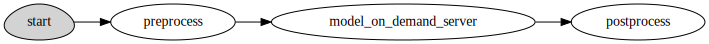

In [9]:
# Create the function:
serving_function = mlrun.code_to_function(
    name="model-on-demand-serving", 
    kind="serving", 
    image="mlrun/ml-models",
)

# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to(class_name="ModelOnDemandServer", name="model_on_demand_server")\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

## Test Via Mock Server

In [10]:
# Create our server:
server = serving_function.to_mock_server()

In [11]:
# Setup the events:
tests = 5  # Amount of events to test
events = [
    {
        EventKeys.MODEL_NAME: list(models.keys())[model],
        EventKeys.MODEL_UID: list(models.values())[model],
        EventKeys.INPUTS: np.random.random((3,5)).tolist()
    } for model in np.random.randint(len(models), size=tests)
]

# Run the events thorugh the serving graph:
for i, event in enumerate(events, 1):
    print(f"Test {i}:")
    response = server.test(path='/predict', body=event)
    print(f"Response: {response}")
    print()

Test 1:
Got inputs: {'model_name': 'GradientBoostingClassifier', 'model_uid': 'store://artifacts/model-on-demand-guyl/GradientBoostingClassifier:ade68544cb2d48e68721172f4e4f0444', 'inputs': [[0.15091620250800808, 0.08071649092461042, 0.3349203647999165, 0.6218115749900299, 0.24366278223976912], [0.8469217267777421, 0.030182201466866787, 0.9298493902511783, 0.29069623483832174, 0.47849534554017625], [0.26120482591881355, 0.007138333748626713, 0.47539244579547, 0.5616416768104301, 0.908806473363008]]}
Loading model...
Loaded model: GradientBoostingClassifier
Predicting...
Predicted:
[[0.34250668 0.65749332]
 [0.1174991  0.8825009 ]
 [0.1269753  0.8730247 ]]
Releasing model from memory...
Released and deleted model file: /tmp/tmpuynco4a3.pkl
Response: {'prediction': [1, 1, 1], 'probability': [0.6574933176868663, 0.8825008981996619, 0.8730247045292162]}

Test 2:
Got inputs: {'model_name': 'GradientBoostingClassifier', 'model_uid': 'store://artifacts/model-on-demand-guyl/GradientBoostingCla

## Deploy

In [12]:
# Mount it:
serving_function.apply(mlrun.platforms.auto_mount())

# Deploy it:
serving_function.deploy()

> 2022-05-19 14:49:43,531 [info] Starting remote function deploy
2022-05-19 14:49:43  (info) Deploying function
2022-05-19 14:49:43  (info) Building
2022-05-19 14:49:43  (info) Staging files and preparing base images
2022-05-19 14:49:44  (info) Building processor image
2022-05-19 14:51:59  (info) Build complete
2022-05-19 14:52:11  (info) Function deploy complete
> 2022-05-19 14:52:12,104 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['model-on-demand-guyl-model-on-demand-serving-model-on-jcpkt3es.default-tenant.app.yh43.iguazio-cd1.com/']}


'http://model-on-demand-guyl-model-on-demand-serving-model-on-jcpkt3es.default-tenant.app.yh43.iguazio-cd1.com/'

In [13]:
# Setup the events:
tests = 5  # Amount of events to test
events = [
    {
        EventKeys.MODEL_NAME: list(models.keys())[model],
        EventKeys.MODEL_UID: list(models.values())[model],
        EventKeys.INPUTS: np.random.random((3,5)).tolist()
    } for model in np.random.randint(len(models), size=tests)
]

# Run the events thorugh the serving graph:
for i, event in enumerate(events, 1):
    print(f"Test {i}:")
    response = serving_function.invoke(path='/predict', body=event)
    print(f"Response: {response}")
    print()

Test 1:
> 2022-05-19 14:52:12,154 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [0, 1, 1], 'probability': [0.6582490479640303, 0.8292301745846826, 0.8033226006396991]}

Test 2:
> 2022-05-19 14:52:13,722 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [0, 1, 1], 'probability': [0.5, 0.51, 0.51]}

Test 3:
> 2022-05-19 14:52:13,922 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [1, 1, 1], 'probability': [0.6157039686116867, 0.6714062044217334, 0.8127560705320326]}

Test 4:
> 2022-05-19 14:52:14,078 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-deman